In [37]:
import numpy  as np
import pandas as pd
import nltk
import re
import joblib
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from sklearn.metrics import silhouette_score
from sklearn.feature_extraction.text import TfidfVectorizer

In [38]:
def load_data(file_path: str)->pd.DataFrame:
    return pd.read_csv(file_path)

In [39]:
file_path='../data/processed_data/processed_data.csv'
data=load_data(file_path)

In [40]:
data.head(10)

,ProductId,UserId,Text
0,B001E4KFG0,A3SGXH7AUHU8GW,I have bought several of the Vitality canned d...
1,B00813GRG4,A1D87F6ZCVE5NK,Product arrived labeled as Jumbo Salted Peanut...
2,B000LQOCH0,ABXLMWJIXXAIN,This is a confection that has been around a fe...
3,B000UA0QIQ,A395BORC6FGVXV,If you are looking for the secret ingredient i...
4,B006K2ZZ7K,A1UQRSCLF8GW1T,Great taffy at a great price. There was a wid...
5,B006K2ZZ7K,ADT0SRK1MGOEU,I got a wild hair for taffy and ordered this f...
6,B006K2ZZ7K,A1SP2KVKFXXRU1,This saltwater taffy had great flavors and was...
7,B006K2ZZ7K,A3JRGQVEQN31IQ,This taffy is so good. It is very soft and ch...
8,B000E7L2R4,A1MZYO9TZK0BBI,Right now I'm mostly just sprouting this so my...
9,B00171APVA,A21BT40VZCCYT4,This is a very healthy dog food. Good for thei...


In [41]:
nltk.download('stopwords')
stop_words=set(stopwords.words('english'))

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\user\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [42]:
def process_text(text):
    text=re.sub(r'[^\w\s]','',text.lower())
    words=text.split()

    words=[word for word in words if word not in stop_words]
    return " ".join(words)

In [43]:
def process_data(dataset:pd.DataFrame , save_path: str)->None:
    dataset['Cleaned_Text']=dataset['Text'].apply(process_text)
    dataset=dataset.drop('Text',axis=1)
    dataset.to_csv(save_path,index=False)

In [45]:
save_path='../data/processed_data/processed_data.csv'
data=process_data(data,save_path)

In [47]:
file_path='..\data\processed_data\processed_data.csv'
data1=load_data(file_path)
data1=data1.head(200000)

<>:1: SyntaxWarning: invalid escape sequence '\d'
<>:1: SyntaxWarning: invalid escape sequence '\d'
C:\Users\user\AppData\Local\Temp\ipykernel_13220\1948195088.py:1: SyntaxWarning: invalid escape sequence '\d'
  file_path='..\data\processed_data\processed_data.csv'


In [48]:
data1.shape

(200000, 3)

In [49]:
def  TFVectorize_text(data1):
    vectorizer = TfidfVectorizer(max_features=2500)
    X_tfidf = vectorizer.fit_transform(data1['Cleaned_Text'])

    joblib.dump(vectorizer,'../models/tfidf_vectorizer.pkl')


    return X_tfidf,vectorizer

In [50]:
x_tfidf, vec = TFVectorize_text(data1)

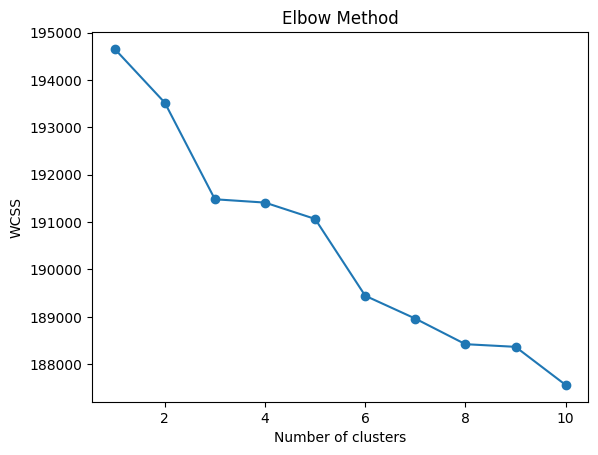

In [51]:
wcss = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters=i)
    kmeans.fit(x_tfidf)
    wcss.append(kmeans.inertia_)

plt.plot(range(1, 11), wcss, marker='o')
plt.title('Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()

In [52]:
def train_kmeans_model(x_vec: np.ndarray, n_clusters: int = 6) -> KMeans:
    kmeans_model = KMeans(n_clusters=n_clusters, random_state=42)
    kmeans_model.fit(x_vec)
    joblib.dump(kmeans_model, '../models/kmeans_model.pkl')
    return kmeans_model

In [53]:
kmeans_model = train_kmeans_model(x_tfidf, n_clusters=6)
cluster_labels = kmeans_model.labels_
data1['Cluster'] = cluster_labels

In [54]:
def save_data(dataset:pd.DataFrame ,save_path: str)->None:
    dataset.to_csv(save_path,index=False)
    

In [55]:
save_data(data1,'../data/processed_data/final_data.csv')
data2=load_data('../data/processed_data/final_data.csv')

In [56]:
data2.head()

,ProductId,UserId,Cleaned_Text,Cluster
0,B001E4KFG0,A3SGXH7AUHU8GW,bought several vitality canned dog food produc...,3
1,B00813GRG4,A1D87F6ZCVE5NK,product arrived labeled jumbo salted peanutsth...,0
2,B000LQOCH0,ABXLMWJIXXAIN,confection around centuries light pillowy citr...,5
3,B000UA0QIQ,A395BORC6FGVXV,looking secret ingredient robitussin believe f...,5
4,B006K2ZZ7K,A1UQRSCLF8GW1T,great taffy great price wide assortment yummy ...,0


In [57]:
def evaluate_kmeans_model(model, x_vec) -> dict:
    labels = model.labels_
    
    silhouette = silhouette_score(x_vec, labels)
    """"
        Silhouette Score	Measures how similar an object is to its own cluster vs others. Higher is better.
        
    """
    
    return {
        'Silhouette Score': silhouette,
    } 

In [58]:
report=evaluate_kmeans_model(kmeans_model,x_tfidf)
print(report)

{'Silhouette Score': np.float64(0.0105723684158601)}
